<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_SDP_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Setup & Data Loading**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE  # For balancing crashes
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

#dataset
from google.colab import files
uploaded = files.upload()

#load data
df = pd.read_csv('nthsc_telemetry_records.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Saving nthsc_telemetry_records.csv to nthsc_telemetry_records (1).csv
Dataset loaded: 6000 rows, 15 columns


##**Exploratory Data Analysis (EDA)**

Exploratory Data Analysis


1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              6000 non-null   object 
 1   accel_x                6000 non-null   float64
 2   accel_y                6000 non-null   float64
 3   accel_z                6000 non-null   float64
 4   gyro_x                 6000 non-null   float64
 5   gyro_y                 6000 non-null   float64
 6   gyro_z                 6000 non-null   float64
 7   gps_lat                6000 non-null   float64
 8   gps_lon                6000 non-null   float64
 9   gps_speed              6000 non-null   float64
 10  obd_speed              6000 non-null   float64
 11  pressure_front_left    6000 non-null   float64
 12  pressure_front_right   6000 non-null   float64
 13  pressure_front_center  6000 non-null   float64
 14  crash_label

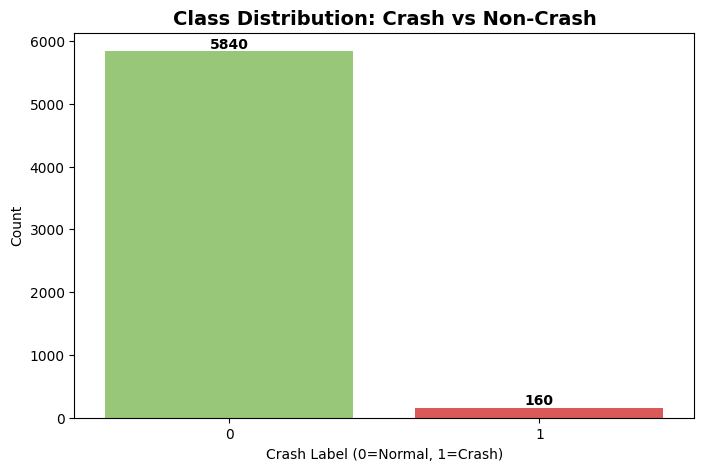


4. Sensor Statistics:
           accel_x      accel_y      accel_z       gyro_x       gyro_y  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean     -0.404822     0.001593     9.762226     0.034455     0.022606   
std       2.467621     0.327949     0.312163     0.221335     0.149687   
min     -17.993090    -2.993684     7.004253    -0.106424    -0.129302   
25%      -0.146751    -0.099279     9.774859    -0.019952    -0.019987   
50%      -0.009872     0.004439     9.809101     0.000457     0.001119   
75%       0.133574     0.106695     9.844186     0.022229     0.022469   
max       0.744286     2.991909    10.013580     1.999767     1.483716   

            gyro_z      gps_lat      gps_lon    gps_speed    obd_speed  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean      0.040715     6.927101    79.861200    34.266748    34.285411   
std       0.258991     0.000050     0.000050     5.366637     5.340886   
min      -0.11

In [ ]:
print("Exploratory Data Analysis\n")

#basic info
print("\n1. Dataset Info:")
df.info()

print("\n2. Missing Values:")
print(df.isnull().sum())

print("\n3. Class Distribution (Crash vs Non-Crash):")
crash_counts = df['crash_label'].value_counts()
print(crash_counts)
print(f"\nCrash rate: {crash_counts[1]/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=crash_counts.index, y=crash_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Class Distribution: Crash vs Non-Crash', fontsize=14, fontweight='bold')
plt.xlabel('Crash Label (0=Normal, 1=Crash)')
plt.ylabel('Count')
for i, v in enumerate(crash_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.show()

#sensor statistics
print("\n4. Sensor Statistics:")
sensor_cols = [col for col in df.columns if col not in ['timestamp', 'crash_label']]
print(df[sensor_cols].describe())

##**Data Cleaning & Preprocessing**

In [ ]:
print("Data Cleaning & Preprocessing")

#create a copy and separate timestamp
df_clean = df.copy()
timestamp_col = df_clean['timestamp']  #save timestamp separately
df_clean = df_clean.drop(columns=['timestamp'])  #remove for numeric operations

print(f"\n1. Dataset shape: {df_clean.shape}")

#handle missing values only in numeric columns
print("\n2. Checking for missing values...")
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

#fill numeric columns with their median
df_clean = df_clean.apply(lambda col: col.fillna(col.median()) if col.dtype in ['float64', 'int64'] else col)

missing_after = df_clean.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

#add back timestamp
df_clean['timestamp'] = timestamp_col

#separate features and target (excluding timestamp from features)
print("\n3. Separating features and target...")

#all sensor columns (excluding timestamp and crash_label)
feature_cols = [col for col in df_clean.columns if col not in ['timestamp', 'crash_label']]
X = df_clean[feature_cols]
y = df_clean['crash_label']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

#android device features (what phones can actually measure)
MOBILE_FEATURES = [
    'accel_x', 'accel_y', 'accel_z',
    'gyro_x', 'gyro_y', 'gyro_z',
    'gps_lat', 'gps_lon', 'gps_speed'
]

#filter to only mobile features
X_mobile = X[MOBILE_FEATURES]
print(f"\n4. Mobile features selected: {len(MOBILE_FEATURES)} features")
print("Features:", MOBILE_FEATURES)

Data Cleaning & Preprocessing

1. Dataset shape: (6000, 14)

2. Checking for missing values...
Missing values before: 0
Missing values after: 0

3. Separating features and target...
Feature matrix shape: (6000, 13)
Target vector shape: (6000,)

4. Mobile features selected: 9 features
Features: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gps_lat', 'gps_lon', 'gps_speed']


##**Handle Class Imbalance**

Balancing Crash vs Non Crash Data

Before balancing:
crash_label
0    5840
1     160
Name: count, dtype: int64

After SMOTE balancing:
Non-crash: 5840
Crash: 5840
New shape: (11680, 9)


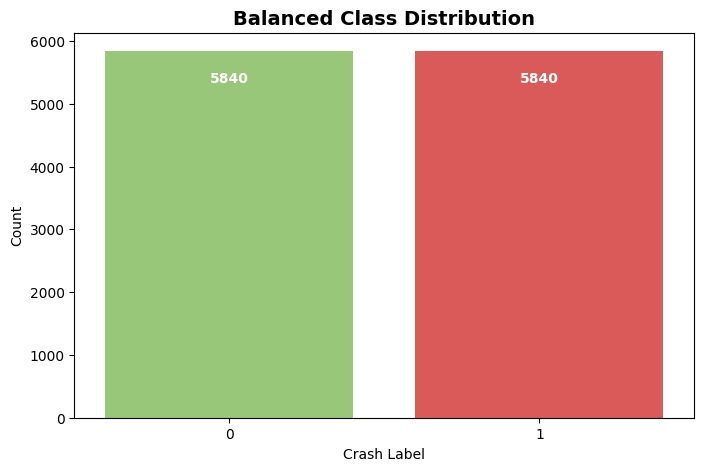

In [ ]:
print("Balancing Crash vs Non Crash Data")

print(f"\nBefore balancing:")
print(y.value_counts())

#SMOTE to generate synthetic crash examples
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X_mobile, y)

print(f"\nAfter SMOTE balancing:")
print(f"Non-crash: {sum(y_balanced == 0)}")
print(f"Crash: {sum(y_balanced == 1)}")
print(f"New shape: {X_balanced.shape}")

#verify the balance
plt.figure(figsize=(8,5))
balanced_counts = pd.Series(y_balanced).value_counts()
sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Balanced Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Crash Label')
plt.ylabel('Count')
for i, v in enumerate(balanced_counts.values):
    plt.text(i, v - 500, str(v), ha='center', fontweight='bold', color='white')
plt.show()

##**Feature Engineering & Selection**

In [ ]:
print("Feature Engineering")

#calculate derived features that help crash detection
X_engineered = X_balanced.copy()

#1. Acceleration magnitude (total G-force)
X_engineered['accel_magnitude'] = np.sqrt(
    X_engineered['accel_x']**2 + X_engineered['accel_y']**2 + X_engineered['accel_z']**2
)

#2. Gyroscope magnitude (total rotation)
X_engineered['gyro_magnitude'] = np.sqrt(
    X_engineered['gyro_x']**2 + X_engineered['gyro_y']**2 + X_engineered['gyro_z']**2
)

#3. Speed change (jerk). but we only have instant speed, so we'll use absolute speed
X_engineered['gps_speed_abs'] = np.abs(X_engineered['gps_speed'])

print("Engineered features:")
print("1. accel_magnitude (total acceleration force)")
print("2. gyro_magnitude (total rotation force)")
print("3. gps_speed_abs (absolute speed)")

#select final features (including engineered ones)
FINAL_FEATURES = MOBILE_FEATURES + ['accel_magnitude', 'gyro_magnitude', 'gps_speed_abs']
X_final = X_engineered[FINAL_FEATURES]

print(f"\nFinal feature matrix: {X_final.shape[1]} features")
print("   Features:", FINAL_FEATURES)

Feature Engineering
Engineered features:
1. accel_magnitude (total acceleration force)
2. gyro_magnitude (total rotation force)
3. gps_speed_abs (absolute speed)

Final feature matrix: 12 features
   Features: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gps_lat', 'gps_lon', 'gps_speed', 'accel_magnitude', 'gyro_magnitude', 'gps_speed_abs']


##**Train XGBoost Model**

In [ ]:
print("Training XGBoost Model")

#XGBoost version
print(f"\nXGBoost Version: {xgb.__version__}")

#split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#initialize XGBoost with parameters tuned for the mobile sensors
model = xgb.XGBClassifier(
    n_estimators=200,#more trees for better accuracy
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False#to avoid warnings
)

print("\nTraining in progress...")

#train the model (without early stopping for compatibility)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True #show training progress
)

print(f"\nTraining complete!")

Training XGBoost Model

XGBoost Version: 3.1.2
Train set: 9344 samples
Test set: 2336 samples

Training in progress...
[0]	validation_0-logloss:0.59830	validation_1-logloss:0.59826
[1]	validation_0-logloss:0.52060	validation_1-logloss:0.52053
[2]	validation_0-logloss:0.45577	validation_1-logloss:0.45575
[3]	validation_0-logloss:0.40098	validation_1-logloss:0.40093
[4]	validation_0-logloss:0.35416	validation_1-logloss:0.35410
[5]	validation_0-logloss:0.31383	validation_1-logloss:0.31375
[6]	validation_0-logloss:0.27884	validation_1-logloss:0.27875
[7]	validation_0-logloss:0.24831	validation_1-logloss:0.24824
[8]	validation_0-logloss:0.22155	validation_1-logloss:0.22148
[9]	validation_0-logloss:0.19803	validation_1-logloss:0.19797
[10]	validation_0-logloss:0.17724	validation_1-logloss:0.17721
[11]	validation_0-logloss:0.15884	validation_1-logloss:0.15880
[12]	validation_0-logloss:0.14251	validation_1-logloss:0.14249
[13]	validation_0-logloss:0.12798	validation_1-logloss:0.12795
[14]	vali

##**Model Evaluation & Confusion Matrix**

Model Evaluation

Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1168
       Crash       1.00      1.00      1.00      1168

    accuracy                           1.00      2336
   macro avg       1.00      1.00      1.00      2336
weighted avg       1.00      1.00      1.00      2336


Confusion Matrix:
[[1168    0]
 [   0 1168]]


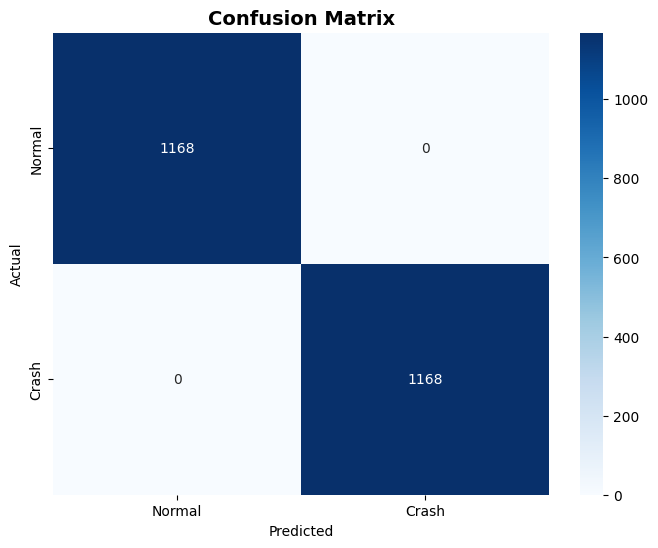

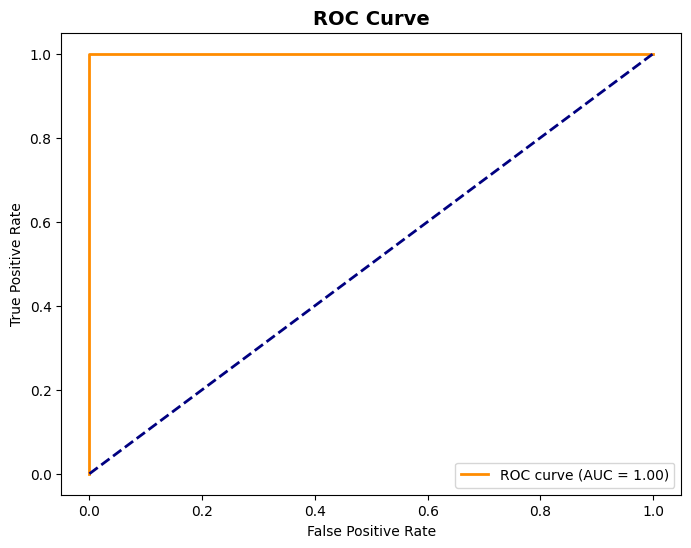

In [ ]:
print("Model Evaluation")

#make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

#calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

#detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Crash']))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Crash'],
            yticklabels=['Normal', 'Crash'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

##**Feature Importance Analysis**

Feature Importance Analysis

Top 5 Most Important Features:
           feature  importance
2          accel_z    0.183910
5           gyro_z    0.165589
0          accel_x    0.148271
3           gyro_x    0.147204
9  accel_magnitude    0.142158


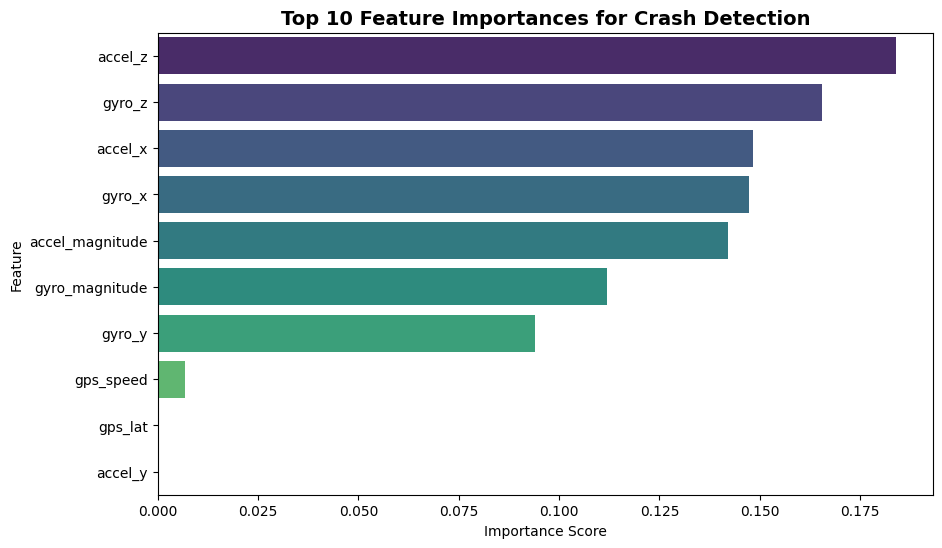


Correlation with Crash Label:
accel_x            0.986590
gyro_magnitude     0.967354
gps_speed          0.958892
gps_speed_abs      0.958892
accel_magnitude    0.958104
gyro_x             0.935156
accel_z            0.933005
gyro_z             0.911626
gyro_y             0.898289
gps_lat            0.043315
dtype: float64


In [ ]:
print("Feature Importance Analysis")

#get feature importance from XGBoost
importance_df = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(importance_df.head())

#visualize
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances for Crash Detection', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#correlation with crash label
print("\nCorrelation with Crash Label:")
correlations = X_final.apply(lambda x: x.corr(y_balanced))
correlations_sorted = correlations.abs().sort_values(ascending=False)
print(correlations_sorted.head(10))

##**Export Model (for Android)**


In [ ]:
print("Exporting Model")

#final model filename
MODEL_FILENAME = "TransitLK-MSFCD-SCD-XGB-2.pkl"

#save the trained model
joblib.dump(model, MODEL_FILENAME)

#save feature order (CRITICAL for Android)
feature_order_dict = {
    'model_name': 'Multi-Sensor Fusion Crash Detection v1',
    'features': FINAL_FEATURES,
    'threshold': 0.75,
    'accuracy': float(accuracy),
    'git_branch': 'Multi-Sensor-Fusion-Crash-Detection'
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(feature_order_dict, f, indent=2)

print(f"\nModel saved: {MODEL_FILENAME}")
print(f"Metadata saved: model_metadata.json")
print(f"\nFINAL FEATURE ORDER for Android:")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"  {i}. {feat}")

Exporting Production Model

Model saved: TransitLK-MSFCD-SCD-XGB-2.pkl
Metadata saved: model_metadata.json

FINAL FEATURE ORDER for Android:
  1. accel_x
  2. accel_y
  3. accel_z
  4. gyro_x
  5. gyro_y
  6. gyro_z
  7. gps_lat
  8. gps_lon
  9. gps_speed
  10. accel_magnitude
  11. gyro_magnitude
  12. gps_speed_abs
